# Late robustness

During the model training, we activate the robustness term only after the model expresses the basic topology of the data
In the robustness phase the decision boundaries are then diffused and robustified

In [1]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
import matplotlib.pyplot as plt
import numpy as np

# Juptyer magic: For export. Makes the plots size right for the screen 
%matplotlib inline
# %config InlineBackend.figure_format = 'retina'

%config InlineBackend.figure_formats = ['svg'] 


torch.backends.cudnn.deterministic = True
seed = np.random.randint(1,200)
# seed = 56
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
print(seed)
g = torch.Generator()
g.manual_seed(seed)

91



# Data preparation

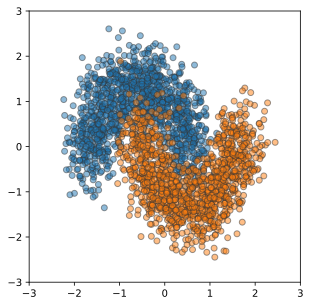

In [2]:
data_noise = 0.25
plotlim = [-3, 3]
subfolder = 'traj_moons'


from models.training import create_dataloader
dataloader, dataloader_viz = create_dataloader('moons', noise = data_noise, plotlim = plotlim, random_state = seed)


## Model dynamics

In [3]:
#Import of the model dynamics that describe the neural ODE
#The dynamics are based on the torchdiffeq package, that implements ODE solvers in the pytorch setting
from models.neural_odes import NeuralODE

#for neural ODE based networks the network width is constant. In this example the input is 2 dimensional
hidden_dim, data_dim = 2, 2 
augment_dim = 0

#T is the end time of the neural ODE evolution, num_steps are the amount of discretization steps for the ODE solver
T, num_steps = 20, 20 
bound = 0.
fp = False #this recent change made things not work anymore
cross_entropy = True
turnpike = False

non_linearity = 'tanh' #'relu' #
architecture = 'inside' #outside


## Training and generating level sets

In [4]:

num_epochs = 120 #number of optimization runs in which the dataset is used for gradient decent
eps = 0.2

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
anode = NeuralODE(device, data_dim, hidden_dim, augment_dim=augment_dim, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_anode = torch.optim.Adam(anode.parameters(), lr=1e-3) 

torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
rnode = NeuralODE(device, data_dim, hidden_dim, augment_dim=0, non_linearity=non_linearity, 
                    architecture=architecture, T=T, time_steps=num_steps, fixed_projector=fp, cross_entropy=cross_entropy)
optimizer_rnode = torch.optim.Adam(rnode.parameters(), lr=1e-3) 

In [5]:
from models.training import doublebackTrainer

trainer_anode = doublebackTrainer(anode, optimizer_anode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps_comp = 0.2) 
trainer_anode.train(dataloader, num_epochs)


Iteration 0/38
Loss: 1.367
Robust Term Loss: 0.080
Accuracy: 0.578

Iteration 10/38
Loss: 1.397
Robust Term Loss: 0.109
Accuracy: 0.469

Iteration 20/38
Loss: 1.074
Robust Term Loss: 0.096
Accuracy: 0.578

Iteration 30/38
Loss: 0.987
Robust Term Loss: 0.070
Accuracy: 0.438
Epoch 1: 1.190

Iteration 0/38
Loss: 0.875
Robust Term Loss: 0.076
Accuracy: 0.453

Iteration 10/38
Loss: 0.747
Robust Term Loss: 0.045
Accuracy: 0.547

Iteration 20/38
Loss: 0.670
Robust Term Loss: 0.078
Accuracy: 0.531

Iteration 30/38
Loss: 0.615
Robust Term Loss: 0.083
Accuracy: 0.594
Epoch 2: 0.704

Iteration 0/38
Loss: 0.610
Robust Term Loss: 0.067
Accuracy: 0.703

Iteration 10/38
Loss: 0.547
Robust Term Loss: 0.092
Accuracy: 0.781

Iteration 20/38
Loss: 0.504
Robust Term Loss: 0.078
Accuracy: 0.844

Iteration 30/38
Loss: 0.506
Robust Term Loss: 0.084
Accuracy: 0.812
Epoch 3: 0.539

Iteration 0/38
Loss: 0.440
Robust Term Loss: 0.067
Accuracy: 0.844

Iteration 10/38
Loss: 0.468
Robust Term Loss: 0.089
Accuracy:

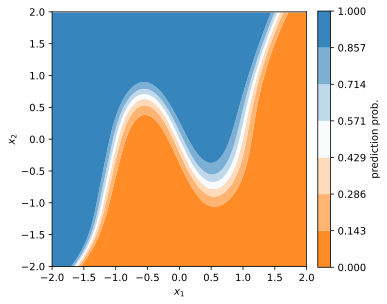

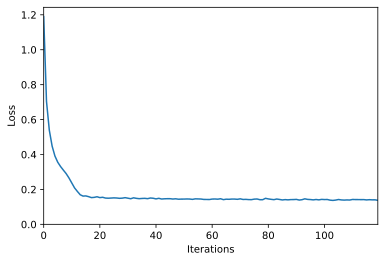

In [6]:
from plots.plots import classification_levelsets
classification_levelsets(anode)
plt.plot(trainer_anode.histories['epoch_loss_history'])
plt.xlim(0, len(trainer_anode.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [7]:
   
w = anode.linear_layer.weight
b = anode.linear_layer.bias

print(w)
print(b)

rnode.linear_layer.weight = w
rnode.linear_layer.bias = b

rnode.linear_layer.requires_grad =  False

Parameter containing:
tensor([[ 0.8071,  0.7560],
        [-0.5472,  0.2794]], requires_grad=True)
Parameter containing:
tensor([0.0631, 0.3805], requires_grad=True)


In [8]:
trainer_rnode = doublebackTrainer(rnode, optimizer_rnode, device, cross_entropy=cross_entropy, turnpike = turnpike,
                         bound=bound, fixed_projector=fp, verbose = True, eps = eps, db_type='l2') 
trainer_rnode.train(dataloader, num_epochs)


Iteration 0/38
Loss: 0.789
Robust Term Loss: 0.019
Accuracy: 0.484

Iteration 10/38
Loss: 0.558
Robust Term Loss: 0.017
Accuracy: 0.531

Iteration 20/38
Loss: 0.524
Robust Term Loss: 0.019
Accuracy: 0.641

Iteration 30/38
Loss: 0.400
Robust Term Loss: 0.021
Accuracy: 0.797
Epoch 1: 0.527

Iteration 0/38
Loss: 0.332
Robust Term Loss: 0.018
Accuracy: 0.859

Iteration 10/38
Loss: 0.361
Robust Term Loss: 0.019
Accuracy: 0.812

Iteration 20/38
Loss: 0.422
Robust Term Loss: 0.021
Accuracy: 0.703

Iteration 30/38
Loss: 0.347
Robust Term Loss: 0.018
Accuracy: 0.844
Epoch 2: 0.371

Iteration 0/38
Loss: 0.284
Robust Term Loss: 0.013
Accuracy: 0.875

Iteration 10/38
Loss: 0.312
Robust Term Loss: 0.023
Accuracy: 0.859

Iteration 20/38
Loss: 0.320
Robust Term Loss: 0.019
Accuracy: 0.859

Iteration 30/38
Loss: 0.286
Robust Term Loss: 0.020
Accuracy: 0.875
Epoch 3: 0.353

Iteration 0/38
Loss: 0.341
Robust Term Loss: 0.016
Accuracy: 0.812

Iteration 10/38
Loss: 0.302
Robust Term Loss: 0.017
Accuracy:

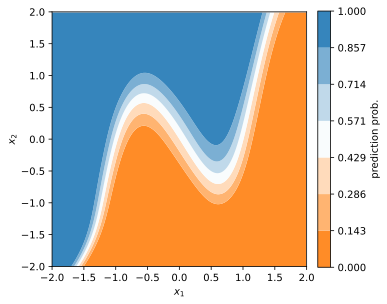

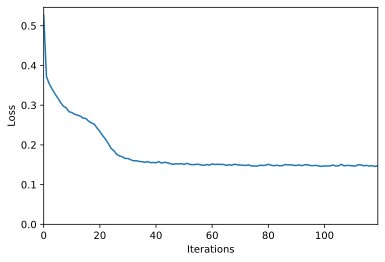

In [9]:
from plots.plots import classification_levelsets
classification_levelsets(rnode)
plt.plot(trainer_rnode.histories['epoch_loss_history'])
plt.xlim(0, len(trainer_rnode.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

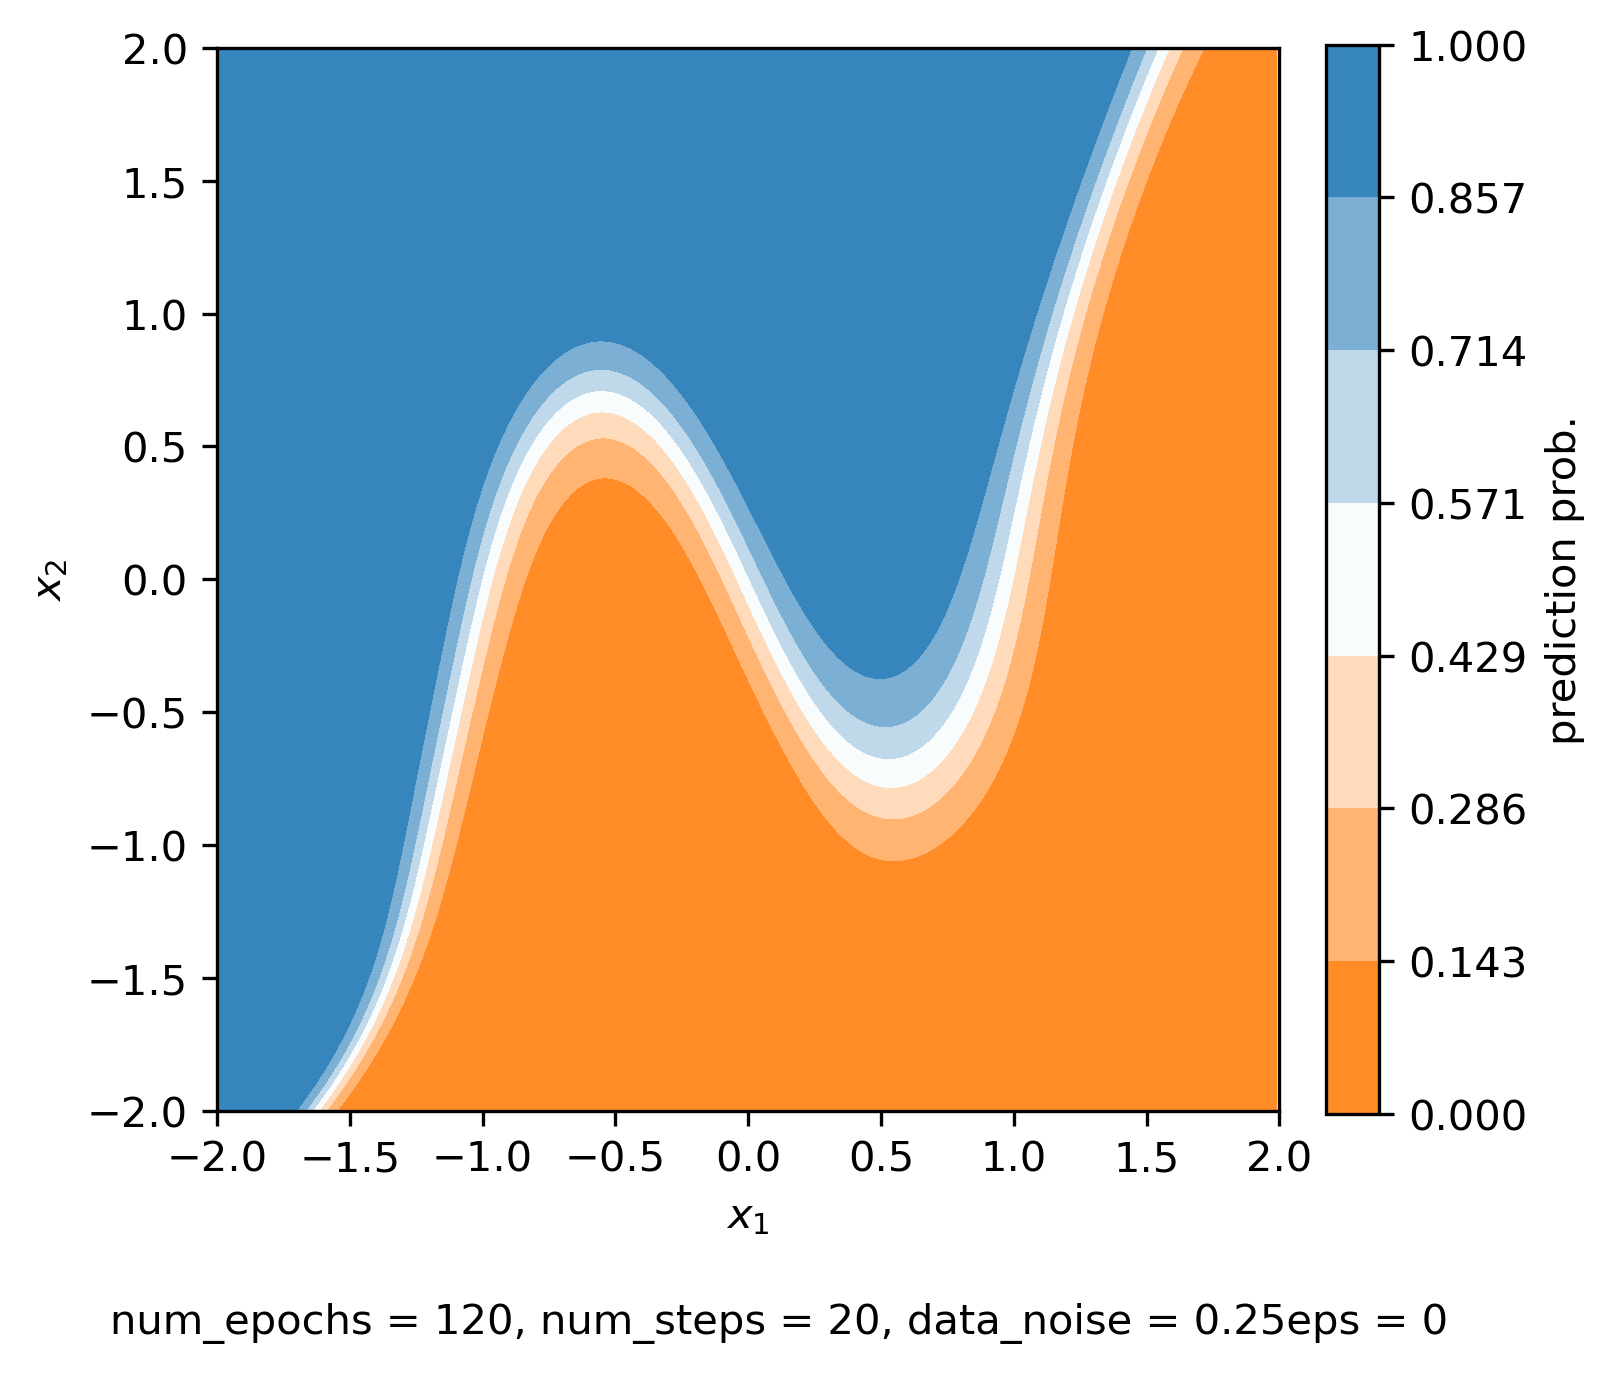

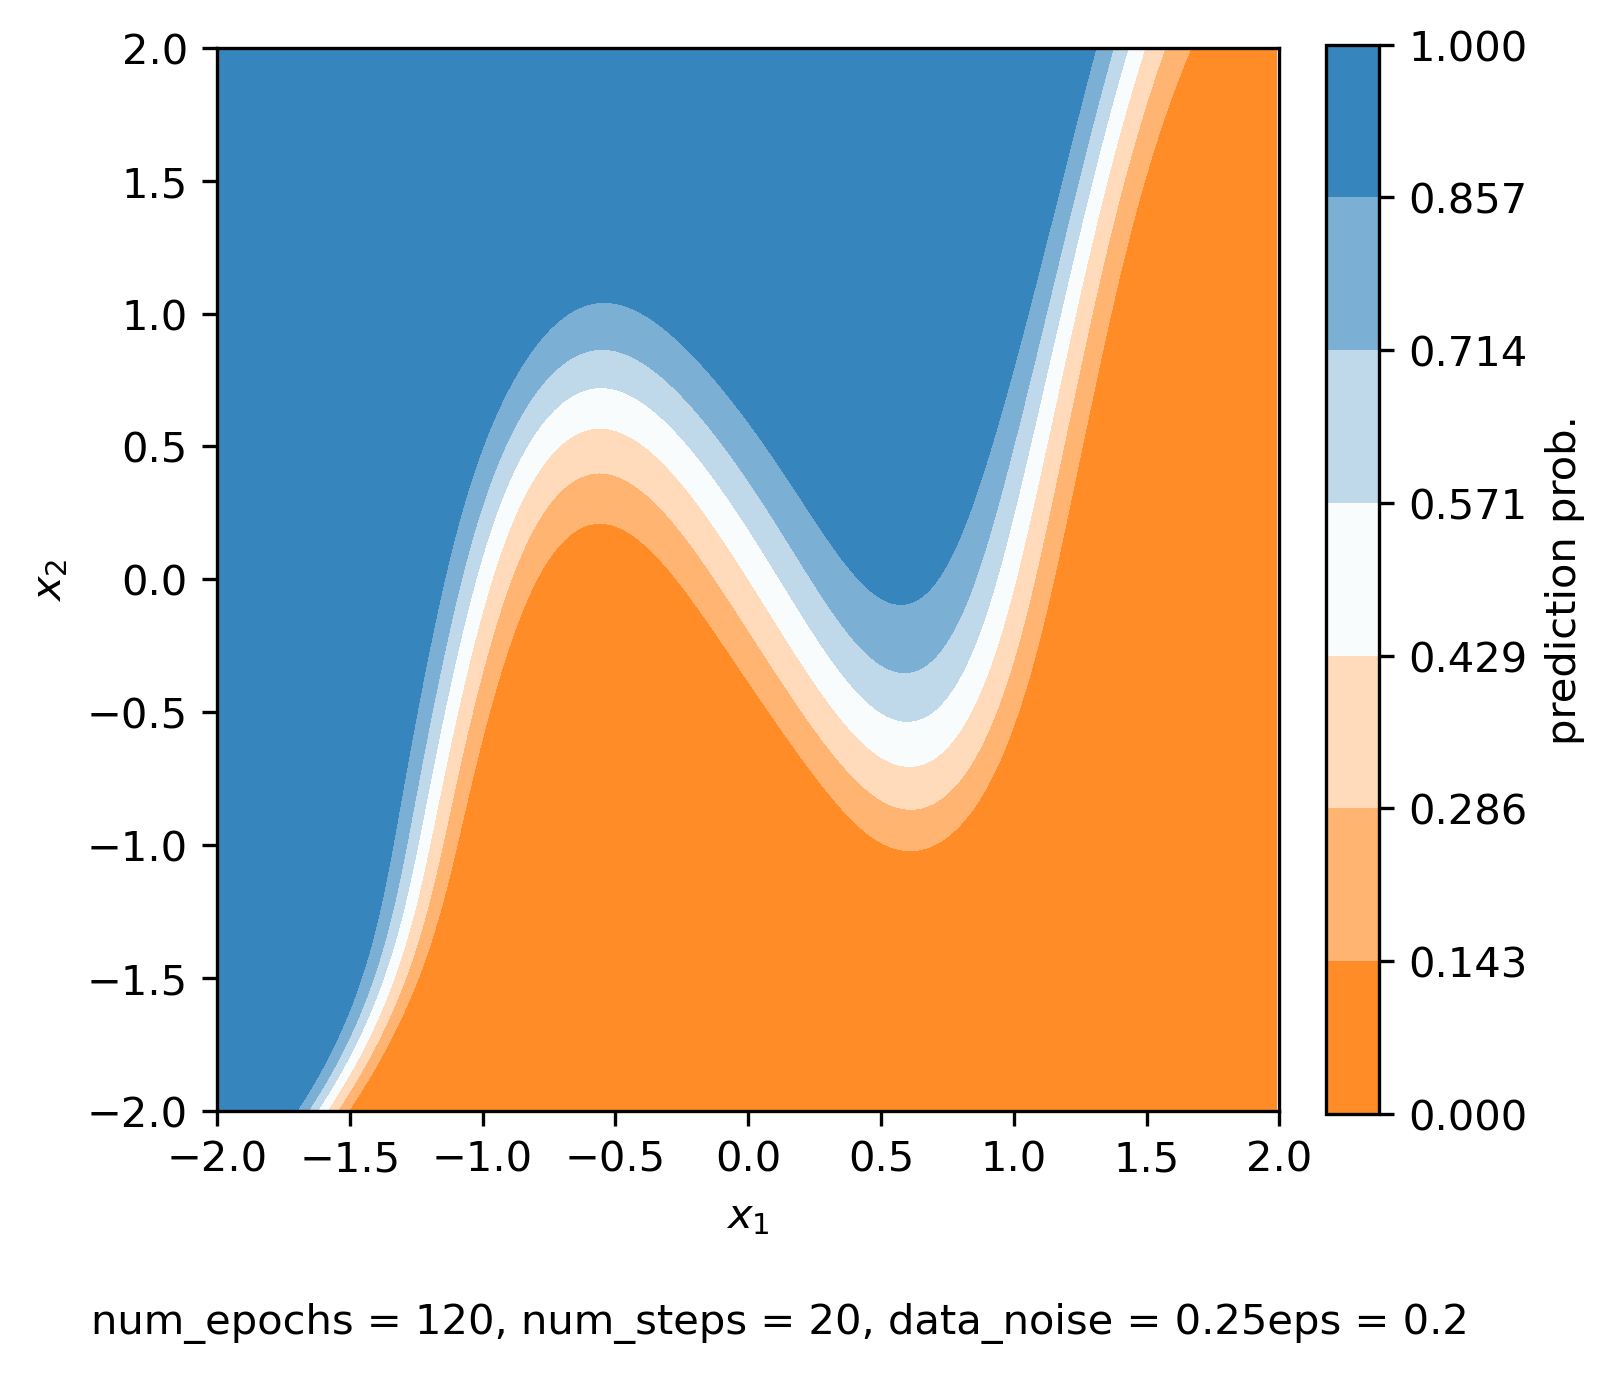

In [10]:
from plots.plots import classification_levelsets
import os

if not os.path.exists(subfolder):
        os.makedirs(subfolder)
        
footnote = f'{num_epochs = }, {num_steps = }, {data_noise = }'
        
fig_name_base = os.path.join(subfolder, 'levelsets')
classification_levelsets(anode, fig_name_base, footnote = footnote + 'eps = 0')
classification_levelsets(rnode, fig_name_base + '_rob', footnote = footnote + f'{eps = }')
from IPython.display import Image
img1 = Image(filename = fig_name_base + '.png', width = 400)
img2 = Image(filename = fig_name_base + '_rob.png', width = 400)

display(img1,img2)

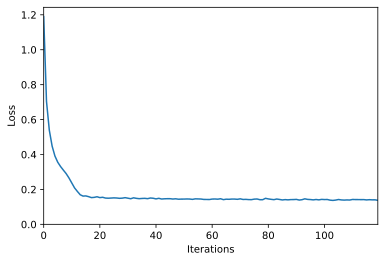

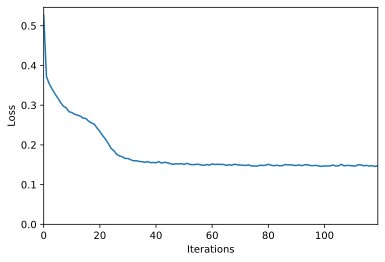

In [11]:
plt.plot(trainer_anode.histories['epoch_loss_history'])
plt.xlim(0, len(trainer_anode.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

plt.plot(trainer_rnode.histories['epoch_loss_history'])
plt.xlim(0, len(trainer_rnode.histories['epoch_loss_history']) - 1)
plt.ylim(0)
plt.xlabel('Iterations')
plt.ylabel('Loss')
plt.show()

In [24]:
for X_viz, y_viz in dataloader_viz:
    X_viz = X_viz[0:5]
    break

trajectories = anode.flow.trajectory(X_viz, 10).detach()
print(X_viz)
print(trajectories.size()) #time is in the first coordinate




tensor([[ 0.1930,  0.3851],
        [-0.1716,  0.7361],
        [ 0.2314,  1.2189],
        [ 1.6835, -0.1532],
        [ 1.4612, -0.6744]])
torch.Size([10, 5, 2])
tensor([0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0,
        1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0,
        0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1,
        0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0,
        0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0,
        0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 1, 0,
        0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0,
        1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0,
        1, 0, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0,
        0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0,
        1, 0, 1, 1, 1, 0, 0, 1, 0, 1

## Lyapunov exponent computation

In [13]:
'''
input: two trajectories x(t), y(t) where each has size (x_dim,len_t)
output: maximum lyapunov exponent for each time t, size (1,len_t)'''
def le(x,y,t):
    d = x - y
    d = torch.linalg.norm(x - y, dim = 0)
    # print(f'{d.shape = }')
    d = d/d[0]
    d = np.log(d)
    

    d = d/t
    return d



'''
Compute the maximum Lyapunov exponent with initial value tolerance eps
input: 
trajectories of size (x_amount,x_amount,x_dim,time_dim)
each trajectory has initial value x_0 = traj[i,j,:,0]

output:
MLE for each trajectory as averaged LE for all initial values that is eps close to the initial value
output size (x_amount,x_amount,t_dim)
'''
def MLE(traj, t, eps = 0.1):
    x_amount = traj.size(0)
    x_amount, y_amount, x_dim, t_dim = traj.shape
    le_val = torch.zeros((x_amount, y_amount, t_dim)) 
    print(f'{le_val.shape = }')
    for i in range(x_amount):
        for j in range(y_amount):
            count = 0
            for i_comp in range(x_amount):
                for j_comp in range(y_amount):
                    if (torch.norm(traj[i,j,:,0] - traj[i_comp,j_comp,:,0]) < eps and not(i == i_comp and j == j_comp)):
                        count += 1
                        le_val[i,j] += le(traj[i,j,:,:],traj[i_comp,j_comp,:,:],t)
                        print('avg le update with count ',count,' and value ',le_val[i,j,-1])
            if count > 1:
                le_val[i,j,:] = le_val[i,j,:]/count
    return le_val



In [14]:

x_amount = 50
eps = 0.1
t = torch.linspace(0,T,2) #only take initial and final time for MLE


x = torch.linspace(-2,2,x_amount)
y = torch.linspace(-2,2,x_amount)
X, Y = torch.meshgrid(x, y)

inputs = torch.stack([X,Y], dim=-1)
print(f'{inputs.size() = }')
# print(inputs)

trajectories = anode.flow.trajectory(inputs, num_steps).detach()
t_indices = torch.tensor([0,-1])

trajectories = trajectories[t_indices] #only take the initial and final time of the trajectory
print('shape of trajectories of grid', trajectories.shape) #MLE works with the time in the last dimension
trajectories = trajectories.permute(1,2,3,0)
print('shape of permuted traj of grid', trajectories.shape) #this fits with the MLE function

output = MLE(trajectories,t,eps)
print(output)
output = output[:,:,-1] #reduce to last time instance T



inputs.size() = torch.Size([50, 50, 2])
shape of trajectories of grid torch.Size([2, 50, 50, 2])
shape of permuted traj of grid torch.Size([50, 50, 2, 2])
le_val.shape = torch.Size([50, 50, 2])
avg le update with count  1  and value  tensor(0.0590)
avg le update with count  2  and value  tensor(0.1403)
avg le update with count  1  and value  tensor(0.0590)
avg le update with count  2  and value  tensor(0.1056)
avg le update with count  3  and value  tensor(0.1777)
avg le update with count  1  and value  tensor(0.0466)
avg le update with count  2  and value  tensor(0.0817)
avg le update with count  3  and value  tensor(0.1477)
avg le update with count  1  and value  tensor(0.0351)
avg le update with count  2  and value  tensor(0.0588)
avg le update with count  3  and value  tensor(0.1205)
avg le update with count  1  and value  tensor(0.0237)
avg le update with count  2  and value  tensor(0.0361)
avg le update with count  3  and value  tensor(0.0947)
avg le update with count  1  and val

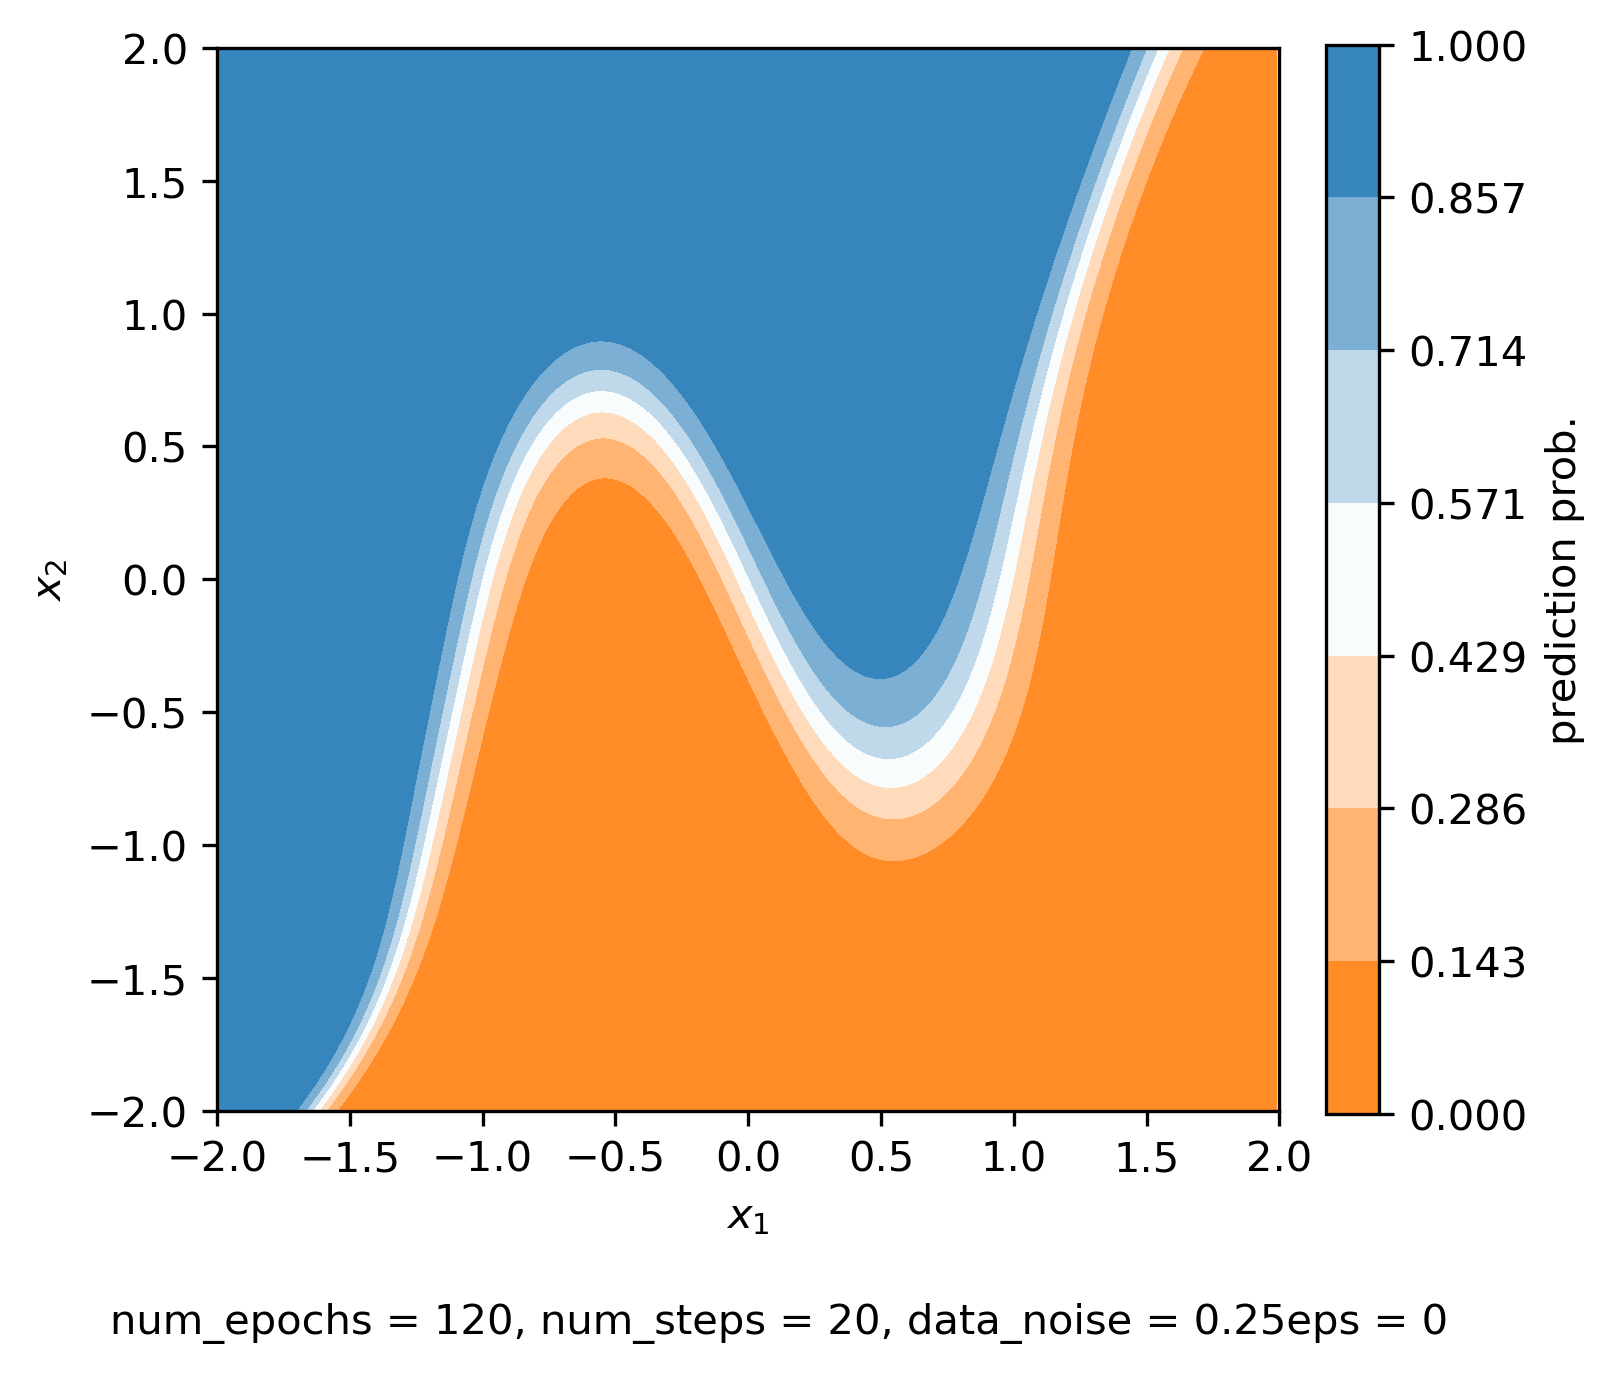

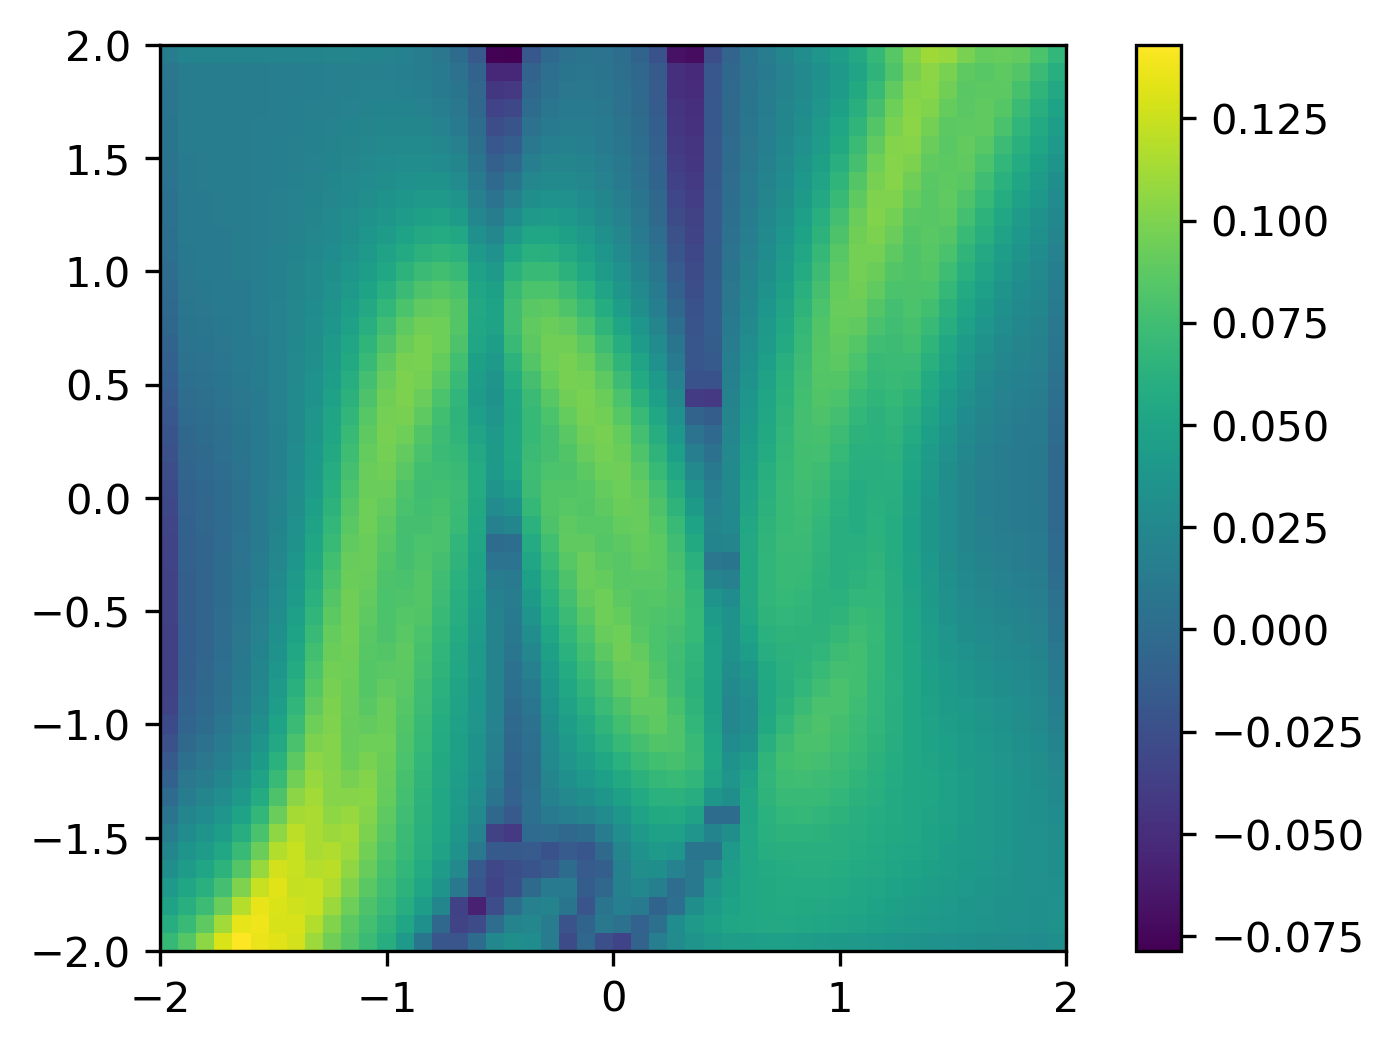

In [15]:
# Create heatmap using imshow
anodeimg = plt.imshow(np.rot90(output), origin='upper', extent=(-2, 2, -2, 2), cmap='viridis')
vmin, vmax = anodeimg.get_clim()
plt.colorbar()  # Show color scale
plt.savefig('MLE.png',bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
plt.close()

img1 = Image(filename = fig_name_base + '.png', width = 400)
img2 = Image(filename = 'MLE.png', width = 400)

display(img1,img2)

In [16]:
rtrajectories = rnode.flow.trajectory(inputs, num_steps).detach()
t_indices = torch.tensor([0,-1])


rtrajectories = rtrajectories[t_indices] #only take the initial and final time of the trajectory
print('shape of trajectories of grid', trajectories.shape) #MLE works with the time in the last dimension
rtrajectories = rtrajectories.permute(1,2,3,0)
print('shape of permuted traj of grid', trajectories.shape) #this fits with the MLE function




routput = MLE(rtrajectories,t,eps)
print(routput)
routput = routput[:,:,-1] #reduce to last time instance T


shape of trajectories of grid torch.Size([50, 50, 2, 2])
shape of permuted traj of grid torch.Size([50, 50, 2, 2])
le_val.shape = torch.Size([50, 50, 2])
avg le update with count  1  and value  tensor(0.0577)
avg le update with count  2  and value  tensor(0.1445)
avg le update with count  1  and value  tensor(0.0577)
avg le update with count  2  and value  tensor(0.1036)
avg le update with count  3  and value  tensor(0.1827)
avg le update with count  1  and value  tensor(0.0460)
avg le update with count  2  and value  tensor(0.0805)
avg le update with count  3  and value  tensor(0.1543)
avg le update with count  1  and value  tensor(0.0346)
avg le update with count  2  and value  tensor(0.0576)
avg le update with count  3  and value  tensor(0.1275)
avg le update with count  1  and value  tensor(0.0230)
avg le update with count  2  and value  tensor(0.0342)
avg le update with count  3  and value  tensor(0.1011)
avg le update with count  1  and value  tensor(0.0111)
avg le update with co

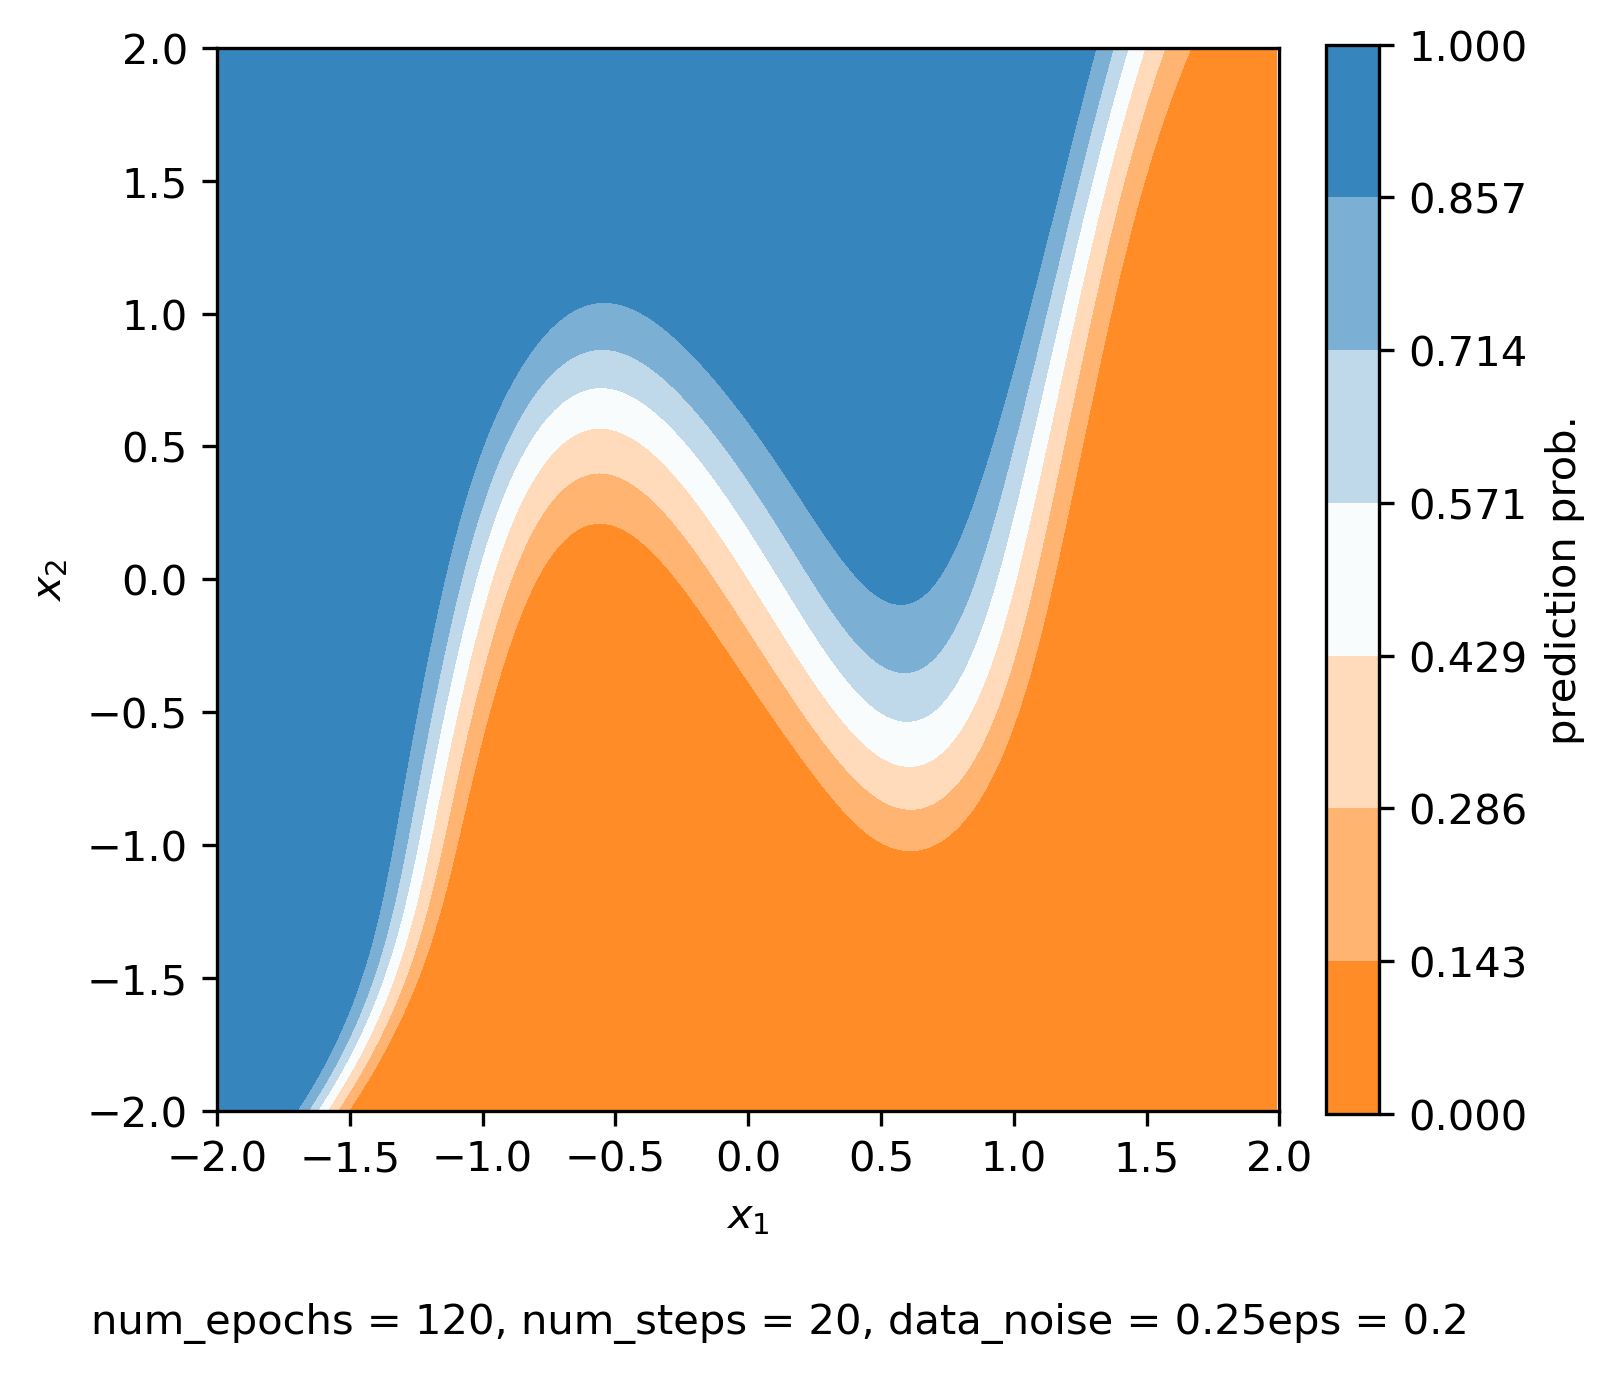

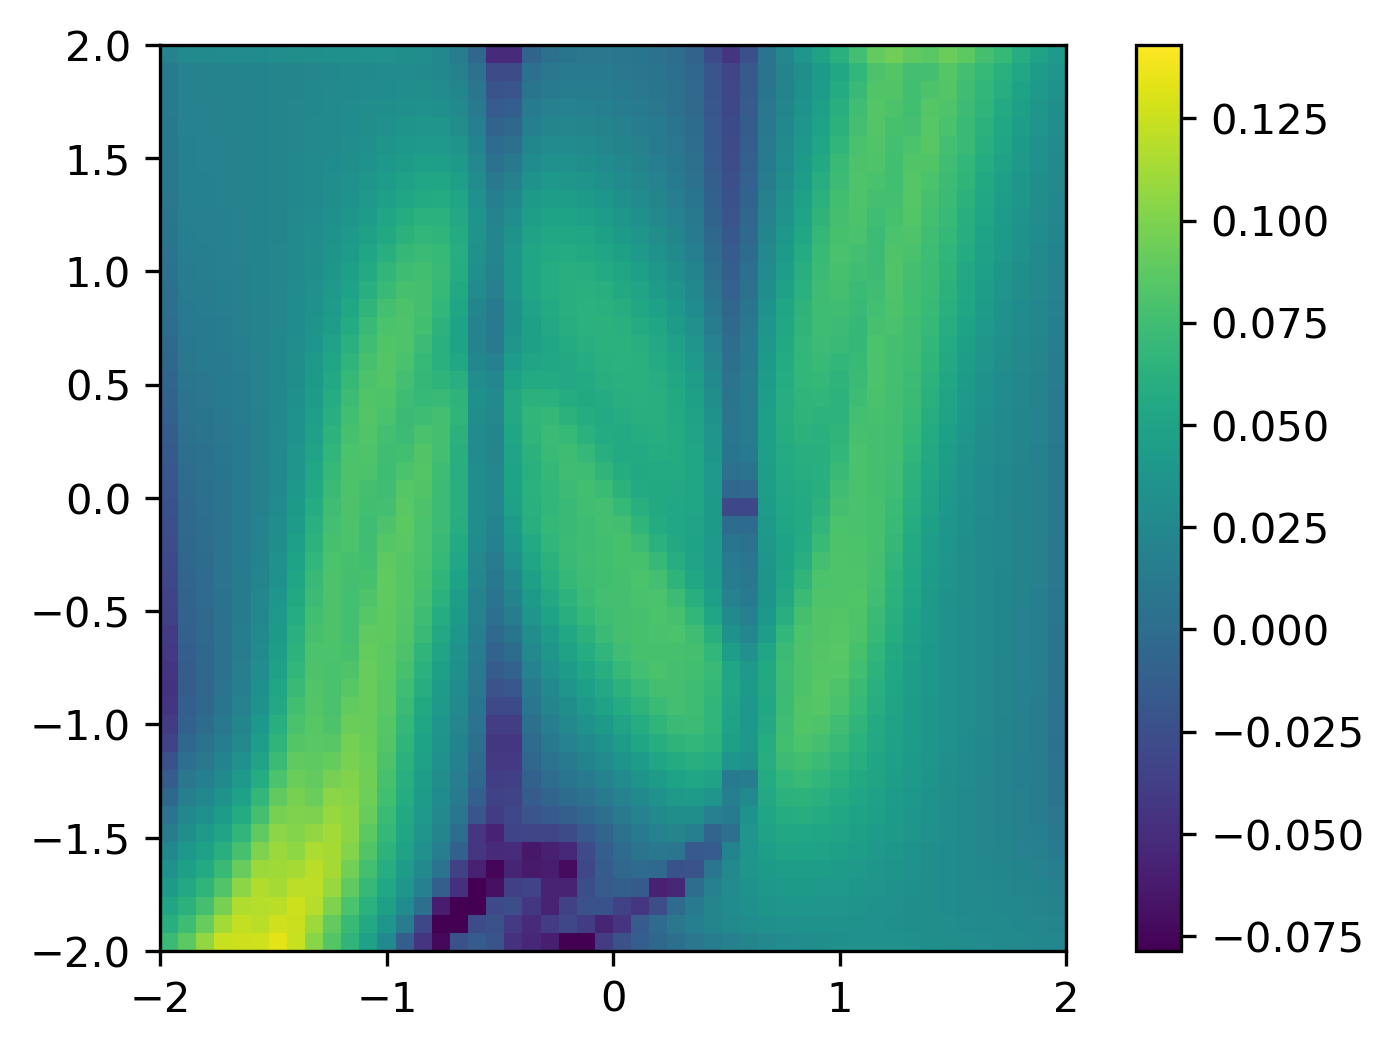

In [17]:
# Create heatmap using imshow

plt.imshow(np.rot90(routput), origin='upper', extent=(-2, 2, -2, 2), cmap='viridis')
plt.clim(vmin,vmax)
plt.colorbar()  # Show color scale
plt.savefig('MLE_rob.png',bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
plt.close()

img1 = Image(filename = fig_name_base + '_rob' + '.png', width = 400)
img2 = Image(filename = 'MLE_rob.png', width = 400)

display(img1,img2)

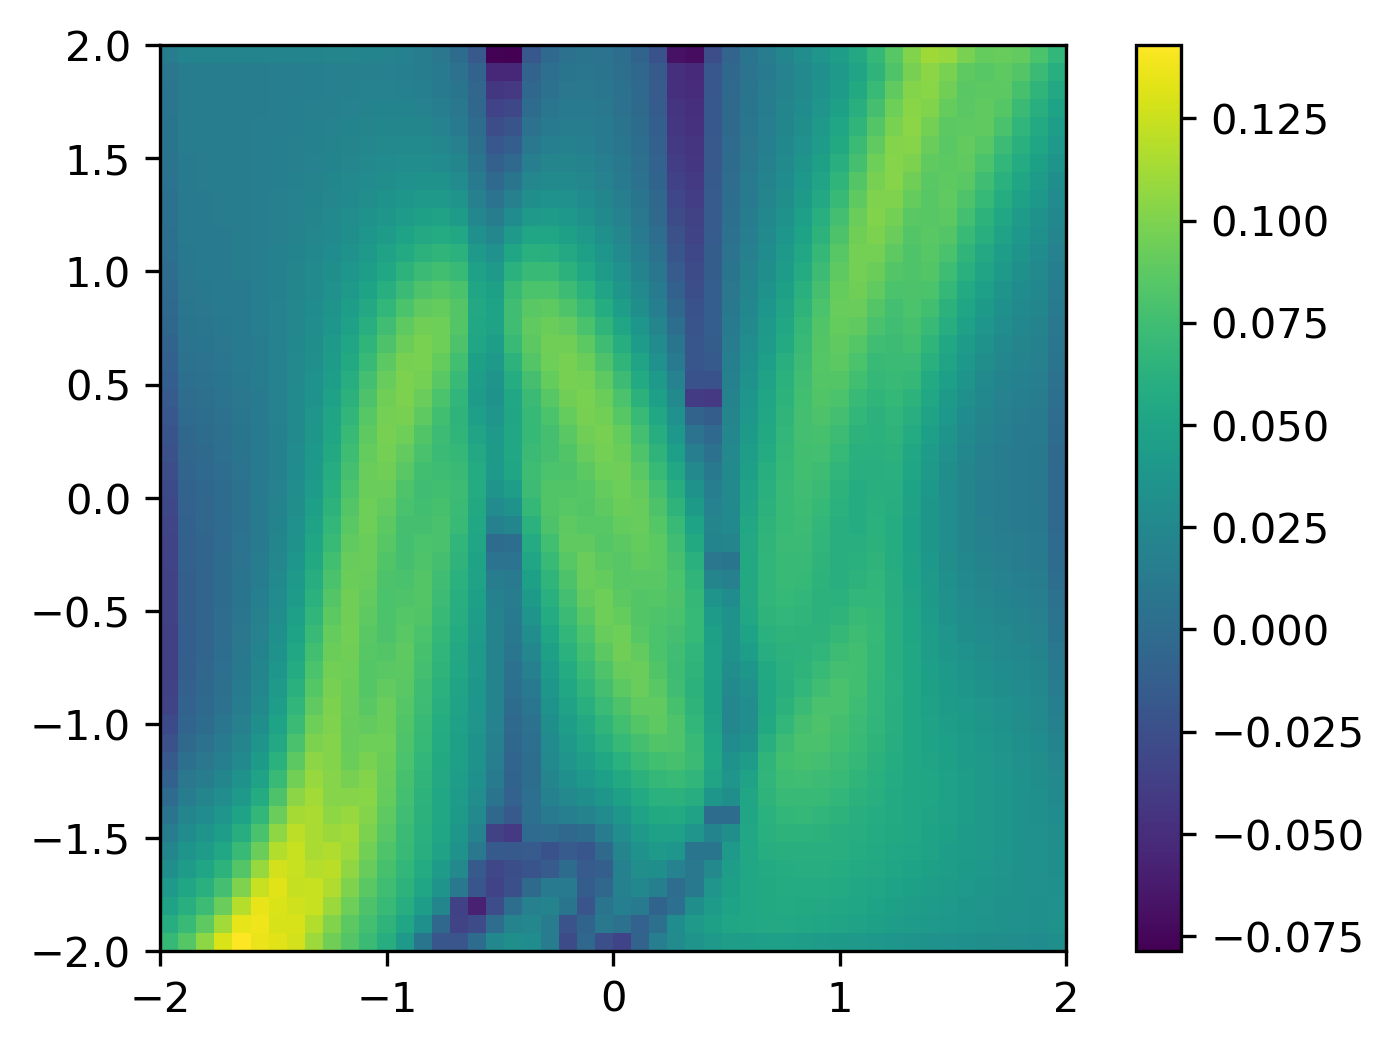

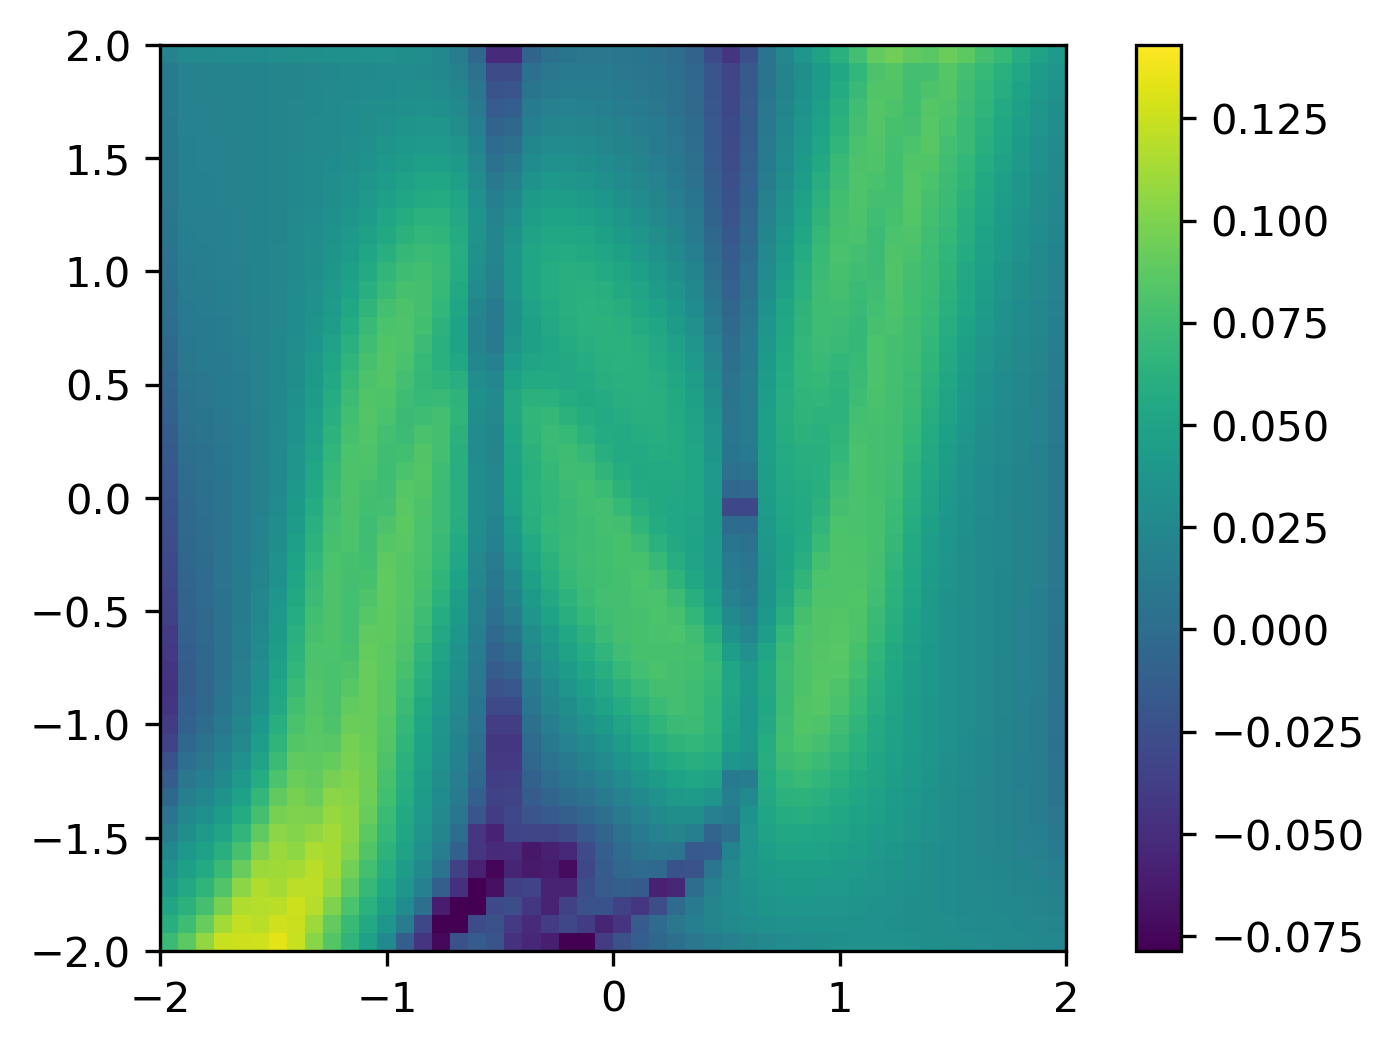

In [18]:
# img1 = Image(filename = fig_name_base + '.png', width = 400)
img2 = Image(filename = 'MLE.png', width = 400)
# img3 = Image(filename = fig_name_base + '_rob' + '.png', width = 400)
img4 = Image(filename = 'MLE_rob.png', width = 400)

display(img2,img4)

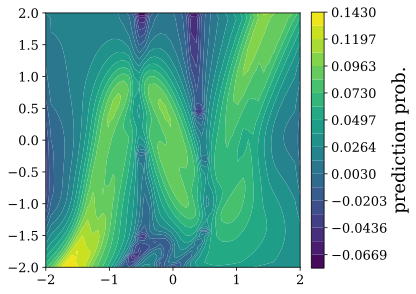

In [23]:
def MLE_test(output, x, y, fig_name=None, footnote=None, contour = True, plotlim = [-1, 1]):
    
    
    fig = plt.figure(figsize=(5, 5), dpi=100)


    x1lower, x1upper = -2, 2
    x2lower, x2upper = -2, 2

    model_inputs = torch.stack([x, y], dim=-1)



    plt.grid(False)
    plt.xlim([x1lower, x1upper])
    plt.ylim([x2lower, x2upper])

    ax = plt.gca()
    ax.set_aspect('equal') 



    z = np.array(output).reshape(x.shape)

    levels = np.linspace(vmin,vmax,20).tolist()

    cont = plt.contourf(x, y, z, levels, alpha=1, zorder = 0, extent=(x1lower, x1upper, x2lower, x2upper)) #plt.get_cmap('coolwarm')
    cbar = fig.colorbar(cont, fraction=0.046, pad=0.04)
    cbar.ax.set_ylabel('prediction prob.')
    
    
MLE_test(output, X, Y)

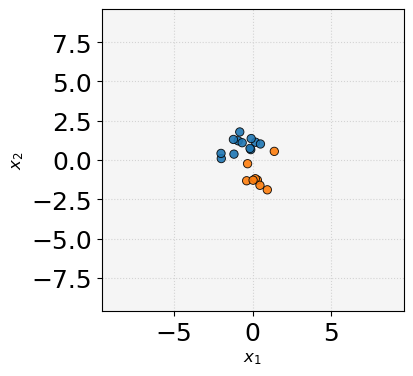

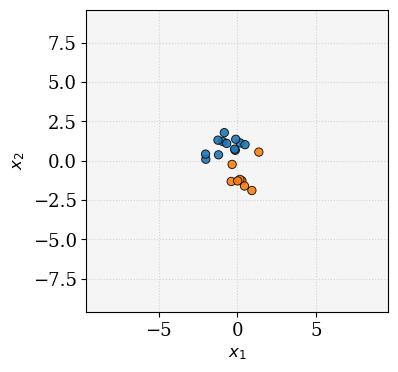

In [20]:
from plots.gifs import trajectory_gif

#the function trajectory_gif creates the evolution trajectories of the input data through the network
#the passing time corresponds to the depth of the network

for X_viz, y_viz in dataloader_viz:
    trajectory_gif(anode, X_viz[0:20], y_viz[0:20], timesteps=num_steps, filename = 'trajectory.gif', axlim = 8, dpi = 100)
    trajectory_gif(rnode, X_viz[0:20], y_viz[0:20], timesteps=num_steps, filename = 'trajectory_db.gif', axlim = 8, dpi = 100)
    break

#Display of the generated gif
traj = Image(filename="trajectory.gif")
rtraj = Image(filename="trajectory_db.gif")
display(traj, rtraj)

FileNotFoundError: No such file: '/Users/tobias/TUMbox/Python/Lyapunov Exponent/trajectory19.png'

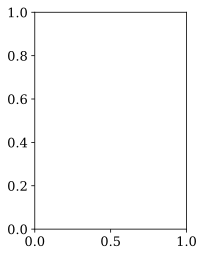

In [21]:
from IPython.display import Image
from plots.plots import comparison_plot
# traj = Image(filename="trajectory19.png", retina = True)
# rtraj = Image(filename="trajectory_db19.png", retina = True)
# display(traj, rtraj)

comparison_plot("trajectory19.png", 'standard training', "trajectory_db19.png", 'robust training', 'traj_comp.png')
display(Image('traj_comp.png', width = 800))

I want to visualize the separation boundary in the final linear layer.

In [ ]:
import matplotlib.pyplot as plt
from matplotlib import rc
import numpy as np
import torch
import torch.nn as nn
from mpl_toolkits.mplot3d import Axes3D

import seaborn as sns
from matplotlib.colors import to_rgb
import imageio

from matplotlib.colors import LinearSegmentedColormap
import os


@torch.no_grad()
def linlayer_levelsets(model, fig_name=None, footnote=None, contour = True, plotlim = [-2, 2]):
    
    
    x1lower, x1upper = plotlim
    x2lower, x2upper = plotlim

    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    fig = plt.figure(figsize=(5, 5), dpi=100)
    
    plt.ylabel(r"$x_2$")
    plt.xlabel(r"$x_1$")
    plt.figtext(0.5, 0, footnote, ha="center", fontsize=10)

    
   
    model.to(device)

    x1 = torch.arange(x1lower, x1upper, step=0.01, device=device)
    x2 = torch.arange(x2lower, x2upper, step=0.01, device=device)
    xx1, xx2 = torch.meshgrid(x1, x2)  # Meshgrid function as in numpy
    model_inputs = torch.stack([xx1, xx2], dim=-1)
    
    preds = model.linear_layer(model_inputs)
    
    # dim = 2 means that it normalizes along the last dimension, i.e. along the two predictions that are the model output
    m = nn.Softmax(dim=2)
    # softmax normalizes the model predictions to probabilities
    preds = m(preds)

    #we only need the probability for being in class1 (as prob for class2 is then 1- class1)
    preds = preds[:, :, 0]
    preds = preds.unsqueeze(2)  # adds a tensor dimension at position 2
    
    plt.grid(False)
    plt.xlim([x1lower, x1upper])
    plt.ylim([x2lower, x2upper])

    ax = plt.gca()
    ax.set_aspect('equal') 
    
    if contour:
        colors = [to_rgb("C1"), [1, 1, 1], to_rgb("C0")] # first color is orange, last is blue
        cm = LinearSegmentedColormap.from_list(
            "Custom", colors, N=40)
        z = np.array(preds).reshape(xx1.shape)
        
        levels = np.linspace(0.,1.,20).tolist()
        
        cont = plt.contourf(xx1, xx2, z, levels, alpha=1, cmap=cm, zorder = 0, extent=(x1lower, x1upper, x2lower, x2upper)) #plt.get_cmap('coolwarm')
        cbar = fig.colorbar(cont, fraction=0.046, pad=0.04)
        cbar.ax.set_ylabel('prediction prob.')
    

    if fig_name:
        plt.savefig(fig_name + '.png', bbox_inches='tight', dpi=300, format='png', facecolor = 'white')
        plt.clf()
        plt.close()
    # else: plt.show()
        

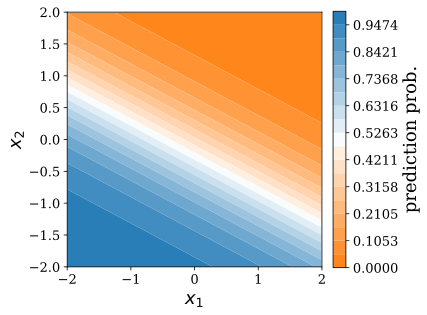

In [ ]:
linlayer_levelsets(anode)

In [ ]:
@torch.no_grad()
def trajectory_gif_new(model, inputs, targets, timesteps, dpi=200, alpha=0.9,
                   alpha_line=1, filename='trajectory.gif', axlim = 0):
    
    from matplotlib import rc
    from scipy.interpolate import interp1d
    rc("text", usetex = False)
    font = {'size'   : 18}
    rc('font', **font)

    if not filename.endswith(".gif"):
        raise RuntimeError("Name must end in with .gif, but ends with {}".format(filename))
    base_filename = filename[:-4]

    ## We focus on 3 colors at most
    if False in (t < 2 for t in targets): 
        color = ['mediumpurple' if targets[i] == 2.0 else 'gold' if targets[i] == 0.0 else 'mediumseagreen' for i in range(len(targets))]
    else:
        #color = ['crimson' if targets[i, 0] > 0.0 else 'dodgerblue' for i in range(len(targets))]
        color = ['C1' if targets[i] > 0.0 else 'dimgrey' for i in range(len(targets))]

    trajectories = model.flow.trajectory(inputs, timesteps).detach()
    num_dims = trajectories.shape[2]

    if axlim == 0:        
        x_min, x_max = trajectories[:, :, 0].min(), trajectories[:, :, 0].max()
        y_min, y_max = trajectories[:, :, 1].min(), trajectories[:, :, 1].max()
    else: 
        x_min, x_max = -axlim, axlim  #to normalize for rob and standard nODE
        y_min, y_max = -axlim, axlim   #
        
    if num_dims == 3:
        z_min, z_max = trajectories[:, :, 2].min(), trajectories[:, :, 2].max()
    margin = 0.1
    x_range = x_max - x_min
    y_range = y_max - y_min
    x_min -= margin * x_range
    x_max += margin * x_range
    y_min -= margin * y_range
    y_max += margin * y_range
    if num_dims == 3:
        z_range = z_max - z_min
        z_min -= margin * z_range
        z_max += margin * z_range
        
    T = model.T 
    integration_time = torch.linspace(0.0, T, timesteps)
    
    interp_x = []
    interp_y = []
    interp_z = []
    for i in range(inputs.shape[0]):
        interp_x.append(interp1d(integration_time, trajectories[:, i, 0], kind='cubic', fill_value='extrapolate'))
        interp_y.append(interp1d(integration_time, trajectories[:, i, 1], kind='cubic', fill_value='extrapolate'))
        if num_dims == 3:
            interp_z.append(interp1d(integration_time, trajectories[:, i, 2], kind='cubic', fill_value='extrapolate'))
    
    interp_time = 20
    # interp_time = 3 #this was 5 before
    _time = torch.linspace(0., T, interp_time)

    plt.rc('grid', linestyle="dotted", color='lightgray')
    for t in range(interp_time):
        if num_dims == 2:
            fig = plt.figure()
            ax = fig.add_subplot(1, 1, 1)
            label_size = 13
            plt.rcParams['xtick.labelsize'] = label_size
            plt.rcParams['ytick.labelsize'] = label_size 
            ax.set_axisbelow(True)
            ax.xaxis.grid(color='lightgray', linestyle='dotted')
            ax.yaxis.grid(color='lightgray', linestyle='dotted')
            ax.set_facecolor('whitesmoke')
            
            plt.xlim(x_min, x_max)
            plt.ylim(y_min, y_max)
            plt.rc('text', usetex=False)
            plt.rc('font', family='serif')
            plt.xlabel(r'$x_1$', fontsize=12)
            plt.ylabel(r'$x_2$', fontsize=12)
            
            x1 = torch.arange(x_min, x_max, step=0.01, device=device)
            x2 = torch.arange(y_min, y_max, step=0.01, device=device)
            xx1, xx2 = torch.meshgrid(x1, x2)  # Meshgrid function as in numpy
            model_inputs = torch.stack([xx1, xx2], dim=-1)
            
            preds = model.linear_layer(model_inputs)
            
            # dim = 2 means that it normalizes along the last dimension, i.e. along the two predictions that are the model output
            m = nn.Softmax(dim=2)
            # softmax normalizes the model predictions to probabilities
            preds = m(preds)

            #we only need the probability for being in class1 (as prob for class2 is then 1- class1)
            preds = preds[:, :, 0]
            preds = preds.unsqueeze(2)  # adds a tensor dimension at position 2
            
            plt.grid(False)
    

            ax = plt.gca()
            ax.set_aspect('equal') 
            
            
            colors = [to_rgb("C1"), [1, 1, 1], to_rgb("C0")] # first color is orange, last is blue
            cm = LinearSegmentedColormap.from_list(
                "Custom", colors, N=40)
            z = np.array(preds).reshape(xx1.shape)
            
            levels = np.linspace(0.,1.,15).tolist()
            
            cont = plt.contourf(xx1, xx2, z, levels, alpha=0.5, cmap=cm, zorder = 0, extent=(x_min, x_max, y_min, y_max)) #plt.get_cmap('coolwarm')
            
            
            
            
            plt.scatter([x(_time)[t] for x in interp_x], 
                         [y(_time)[t] for y in interp_y], 
                         c=color, alpha=alpha, marker = 'o', linewidth=0.65, edgecolors='black', zorder=3)

            if t > 0:
                for i in range(inputs.shape[0]):
                    x_traj = interp_x[i](_time)[:t+1]
                    y_traj = interp_y[i](_time)[:t+1]
                    plt.plot(x_traj, y_traj, c=color[i], alpha=alpha_line, linewidth = 0.75, zorder=1)
            
        
        ax.set_aspect('equal')

        plt.savefig(base_filename + "{}.png".format(t),
                    format='png', dpi=dpi, bbox_inches='tight', facecolor = 'white')
        # Save only 3 frames (.pdf for paper)
        # if t in [0, interp_time//5, interp_time//2, interp_time-1]:
        #     plt.savefig(base_filename + "{}.pdf".format(t), format='pdf', bbox_inches='tight')
        plt.clf()
        plt.close()

    imgs = []
    for i in range(interp_time):
        img_file = base_filename + "{}.png".format(i)
        imgs.append(imageio.imread(img_file))
        if i not in [0, interp_time//5, interp_time//2, interp_time-1]: os.remove(img_file) 
    imageio.mimwrite(filename, imgs, fps = 2)

In [ ]:
from plots.gifs import trajectory_gif

#the function trajectory_gif creates the evolution trajectories of the input data through the network
#the passing time corresponds to the depth of the network

data_iter = iter(dataloader)
X,y = next(data_iter)
batch_size = 40

X_viz = torch.zeros_like(X[0:batch_size])
y_viz = torch.zeros(batch_size)
print(y_viz.size())
print(X_viz.size())
X_viz[:,1] = torch.linspace(-5,5,batch_size)
X_viz[:,0] = torch.tensor([0])
print(X_viz)

# plt.scatter(X_viz[:,0],X_viz[:,1])

trajectory_gif_new(anode, X_viz[0:batch_size], y_viz[0:batch_size], timesteps=num_steps, filename = 'trajectory.gif', axlim = 8, dpi = 100)
trajectory_gif_new(rnode, X_viz[0:batch_size], y_viz[0:batch_size], timesteps=num_steps, filename = 'trajectory_db.gif', axlim = 8, dpi = 100)


torch.Size([40])
torch.Size([40, 2])
tensor([[ 0.0000, -5.0000],
        [ 0.0000, -4.7436],
        [ 0.0000, -4.4872],
        [ 0.0000, -4.2308],
        [ 0.0000, -3.9744],
        [ 0.0000, -3.7179],
        [ 0.0000, -3.4615],
        [ 0.0000, -3.2051],
        [ 0.0000, -2.9487],
        [ 0.0000, -2.6923],
        [ 0.0000, -2.4359],
        [ 0.0000, -2.1795],
        [ 0.0000, -1.9231],
        [ 0.0000, -1.6667],
        [ 0.0000, -1.4103],
        [ 0.0000, -1.1538],
        [ 0.0000, -0.8974],
        [ 0.0000, -0.6410],
        [ 0.0000, -0.3846],
        [ 0.0000, -0.1282],
        [ 0.0000,  0.1282],
        [ 0.0000,  0.3846],
        [ 0.0000,  0.6410],
        [ 0.0000,  0.8974],
        [ 0.0000,  1.1538],
        [ 0.0000,  1.4103],
        [ 0.0000,  1.6667],
        [ 0.0000,  1.9231],
        [ 0.0000,  2.1795],
        [ 0.0000,  2.4359],
        [ 0.0000,  2.6923],
        [ 0.0000,  2.9487],
        [ 0.0000,  3.2051],
        [ 0.0000,  3.4615],
        [ 0

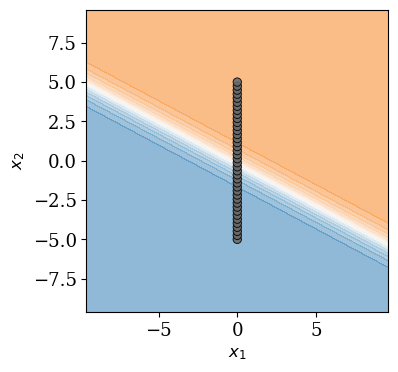

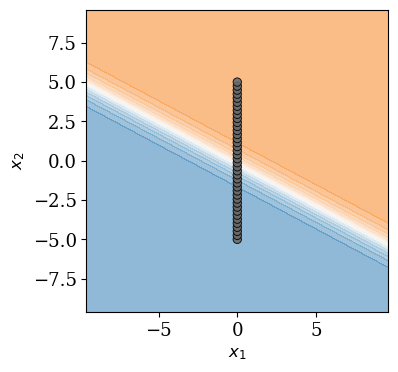

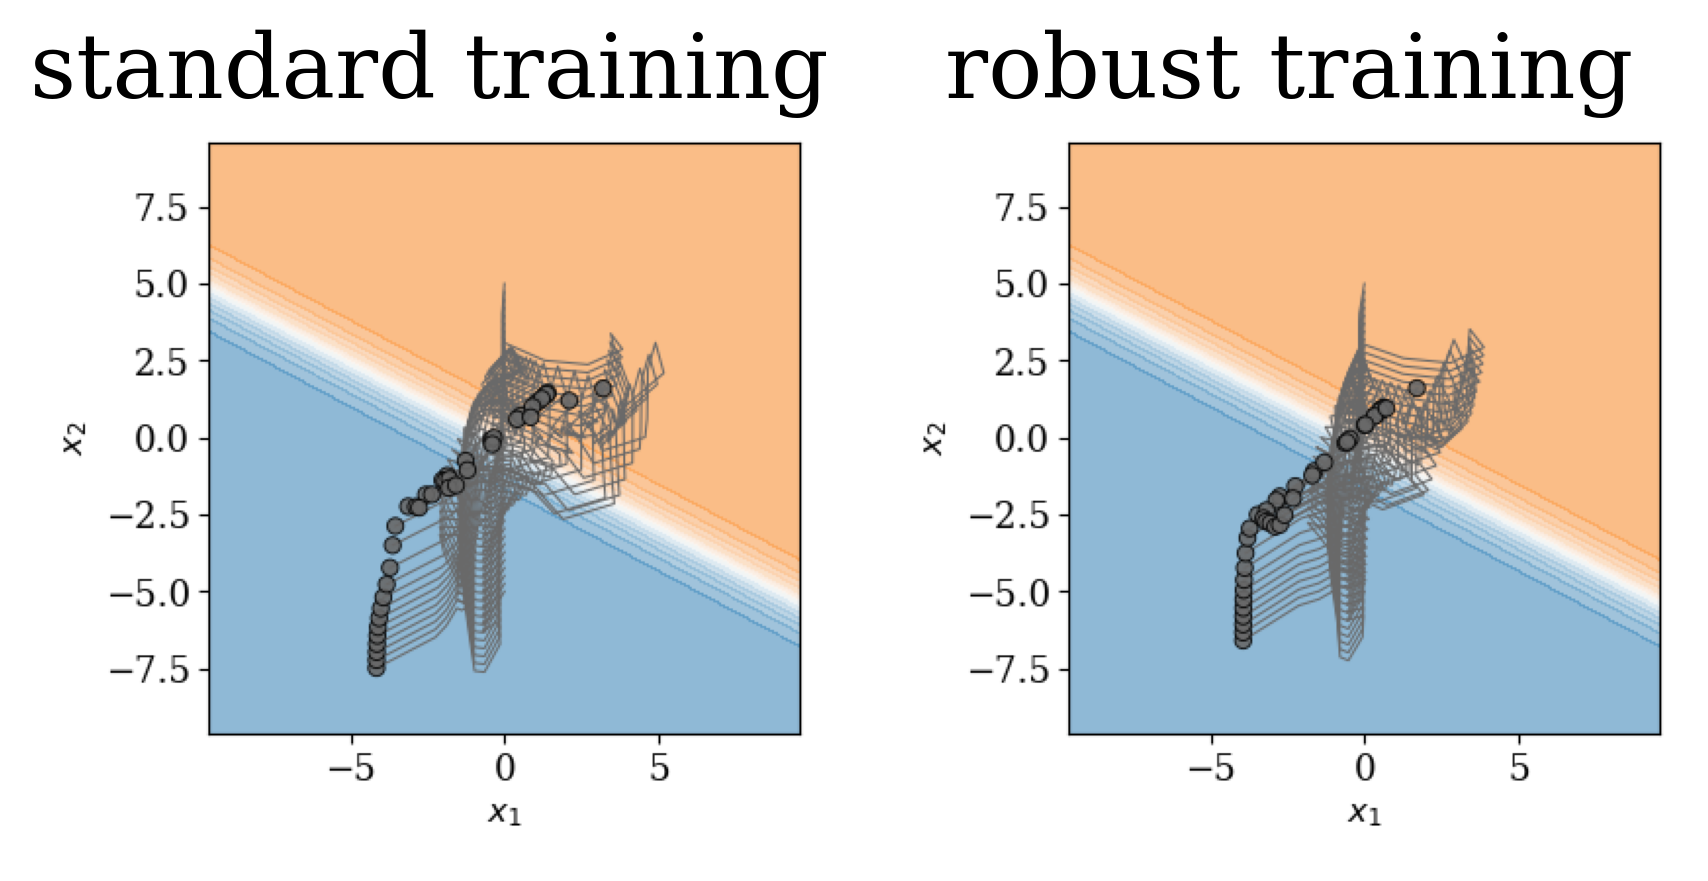

In [ ]:
traj = Image(filename="trajectory.gif")
rtraj = Image(filename="trajectory_db.gif")
display(traj, rtraj)

comparison_plot("trajectory19.png", 'standard training', "trajectory_db19.png", 'robust training', 'traj_comp.png')
display(Image('traj_comp.png', width = 800))

In [ ]:
for X_viz, y_viz in dataloader_viz:
    trajectory_gif_new(anode, X_viz, y_viz, timesteps=num_steps, filename = 'trajectory.gif', axlim = 8, dpi = 100)
    trajectory_gif_new(rnode, X_viz, y_viz, timesteps=num_steps, filename = 'trajectory_db.gif', axlim = 8, dpi = 100)
    break

#Display of the generated gif
traj = Image(filename="trajectory.gif")
rtraj = Image(filename="trajectory_db.gif")
display(traj, rtraj)

comparison_plot("trajectory19.png", 'standard training', "trajectory_db19.png", 'robust training', 'traj_comp.png')
display(Image('traj_comp.png', width = 800))

NameError: name 'trajectory_gif_new' is not defined